In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/sample'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [8]:
dataset = [
    'imagenet',
    'ecoset',
    'imagenet21kP',
    'webvisionP',
    'inaturalist',
    'places365'
]

In [9]:
all_configs = {}

for ds in dataset:
    yaml_config = config_dir / f'{ds}_scaling.yaml'
    all_configs[f"{ds}"] = load_yaml(yaml_config)


In [10]:
L_fit_dict = {key: config['fitting_parameters']['loss_function'] for key, config in all_configs.items()}
L_viz_dict = {key: config['visualization']['loss_function'] for key, config in all_configs.items()}
x_scale_dict = {key: float(config['fitting_parameters']['X_scaler']) for key, config in all_configs.items()}



## Apply Data Filters

In [11]:
all_df = {
    name: apply_filters(df_results, config.get('data_filters', {}))
    for name, config in all_configs.items()
}

## Load Fitting Results

In [12]:
optimized_params_dict = {}
opt_params_boot_dict = {}

for ds in all_configs.keys():
    with open(results_dir / f'sample_{ds}_scaling' / 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    L_fit = L_fit_dict[ds]
    L_viz = L_viz_dict[ds]
    optimized_params_dict[ds] = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

    # Convert bootstrapped parameters
    opt_params_boot = results['optimized_parameters_bootstrapped']
    opt_params_boot_dict[ds] = convert_loss_parameters_batch(
        params=opt_params_boot,
        src_loss=L_fit,
        dst_loss=L_viz
    )

## Visualize

#### Plotting settings

In [13]:
x_extend = 15
X_str = r'$$\tilde{D}$$'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
figsize = (10, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palette = COLOR_PALETTES['datasets']

dataset2colorid = {
    'imagenet': 0,
    'imagenet21kP': 1,
    'ImageNet21kP': 1,
    'webvisionP': 2,
    'WebvisionP': 2,
    'places365': 3,
    'Places365': 3,
    'inaturalist': 4,
    'iNaturalist': 4,
    'ecoset': 5,
}

In [14]:
config = {
    'data_filters': {
        'set_filters': {
            'region': [
                'V1',
                'V2',
                'V4',
                'IT',
                'Behavioral'
                ],
            'dataset': [
                'webvisionP',
                'inaturalist',
                'imagenet21kP',
                'places365',
                ]
            },
    'boolean_filters': {
        'equals_false': [
            'is_pretrained',
            'is_random',
            'is_ssl',
            'is_adv',
            'is_ablation'
            ]
        },
    
    'group_by': {
        'avg_score': {
            'keys': [
                'model_id',
                'arch',
                'dataset',
                'flops',
                'n_params',
                'n_samples',
                'n_samples_seen',
                'total_flops',
                'arch_family',
                'samples_per_class',
                'benchmark_name',
            ],
            'reduce': {'score': 'mean'}}},
    'combine_arch_families': True,
    }
}

In [15]:
df_other = apply_filters(df_results, config.get('data_filters', {}))
df_other.dataset = df_other.dataset.map({
    'webvisionP': 'WebvisionP',
    'inaturalist': 'iNaturalist',
    'imagenet21kP': 'ImageNet21kP',
    'places365': 'Places365',
})
# df_other

In [16]:
linestyles = [
    '--',
    '-.',
    ':',
    (0, (1,1))
    
]

#### Plot

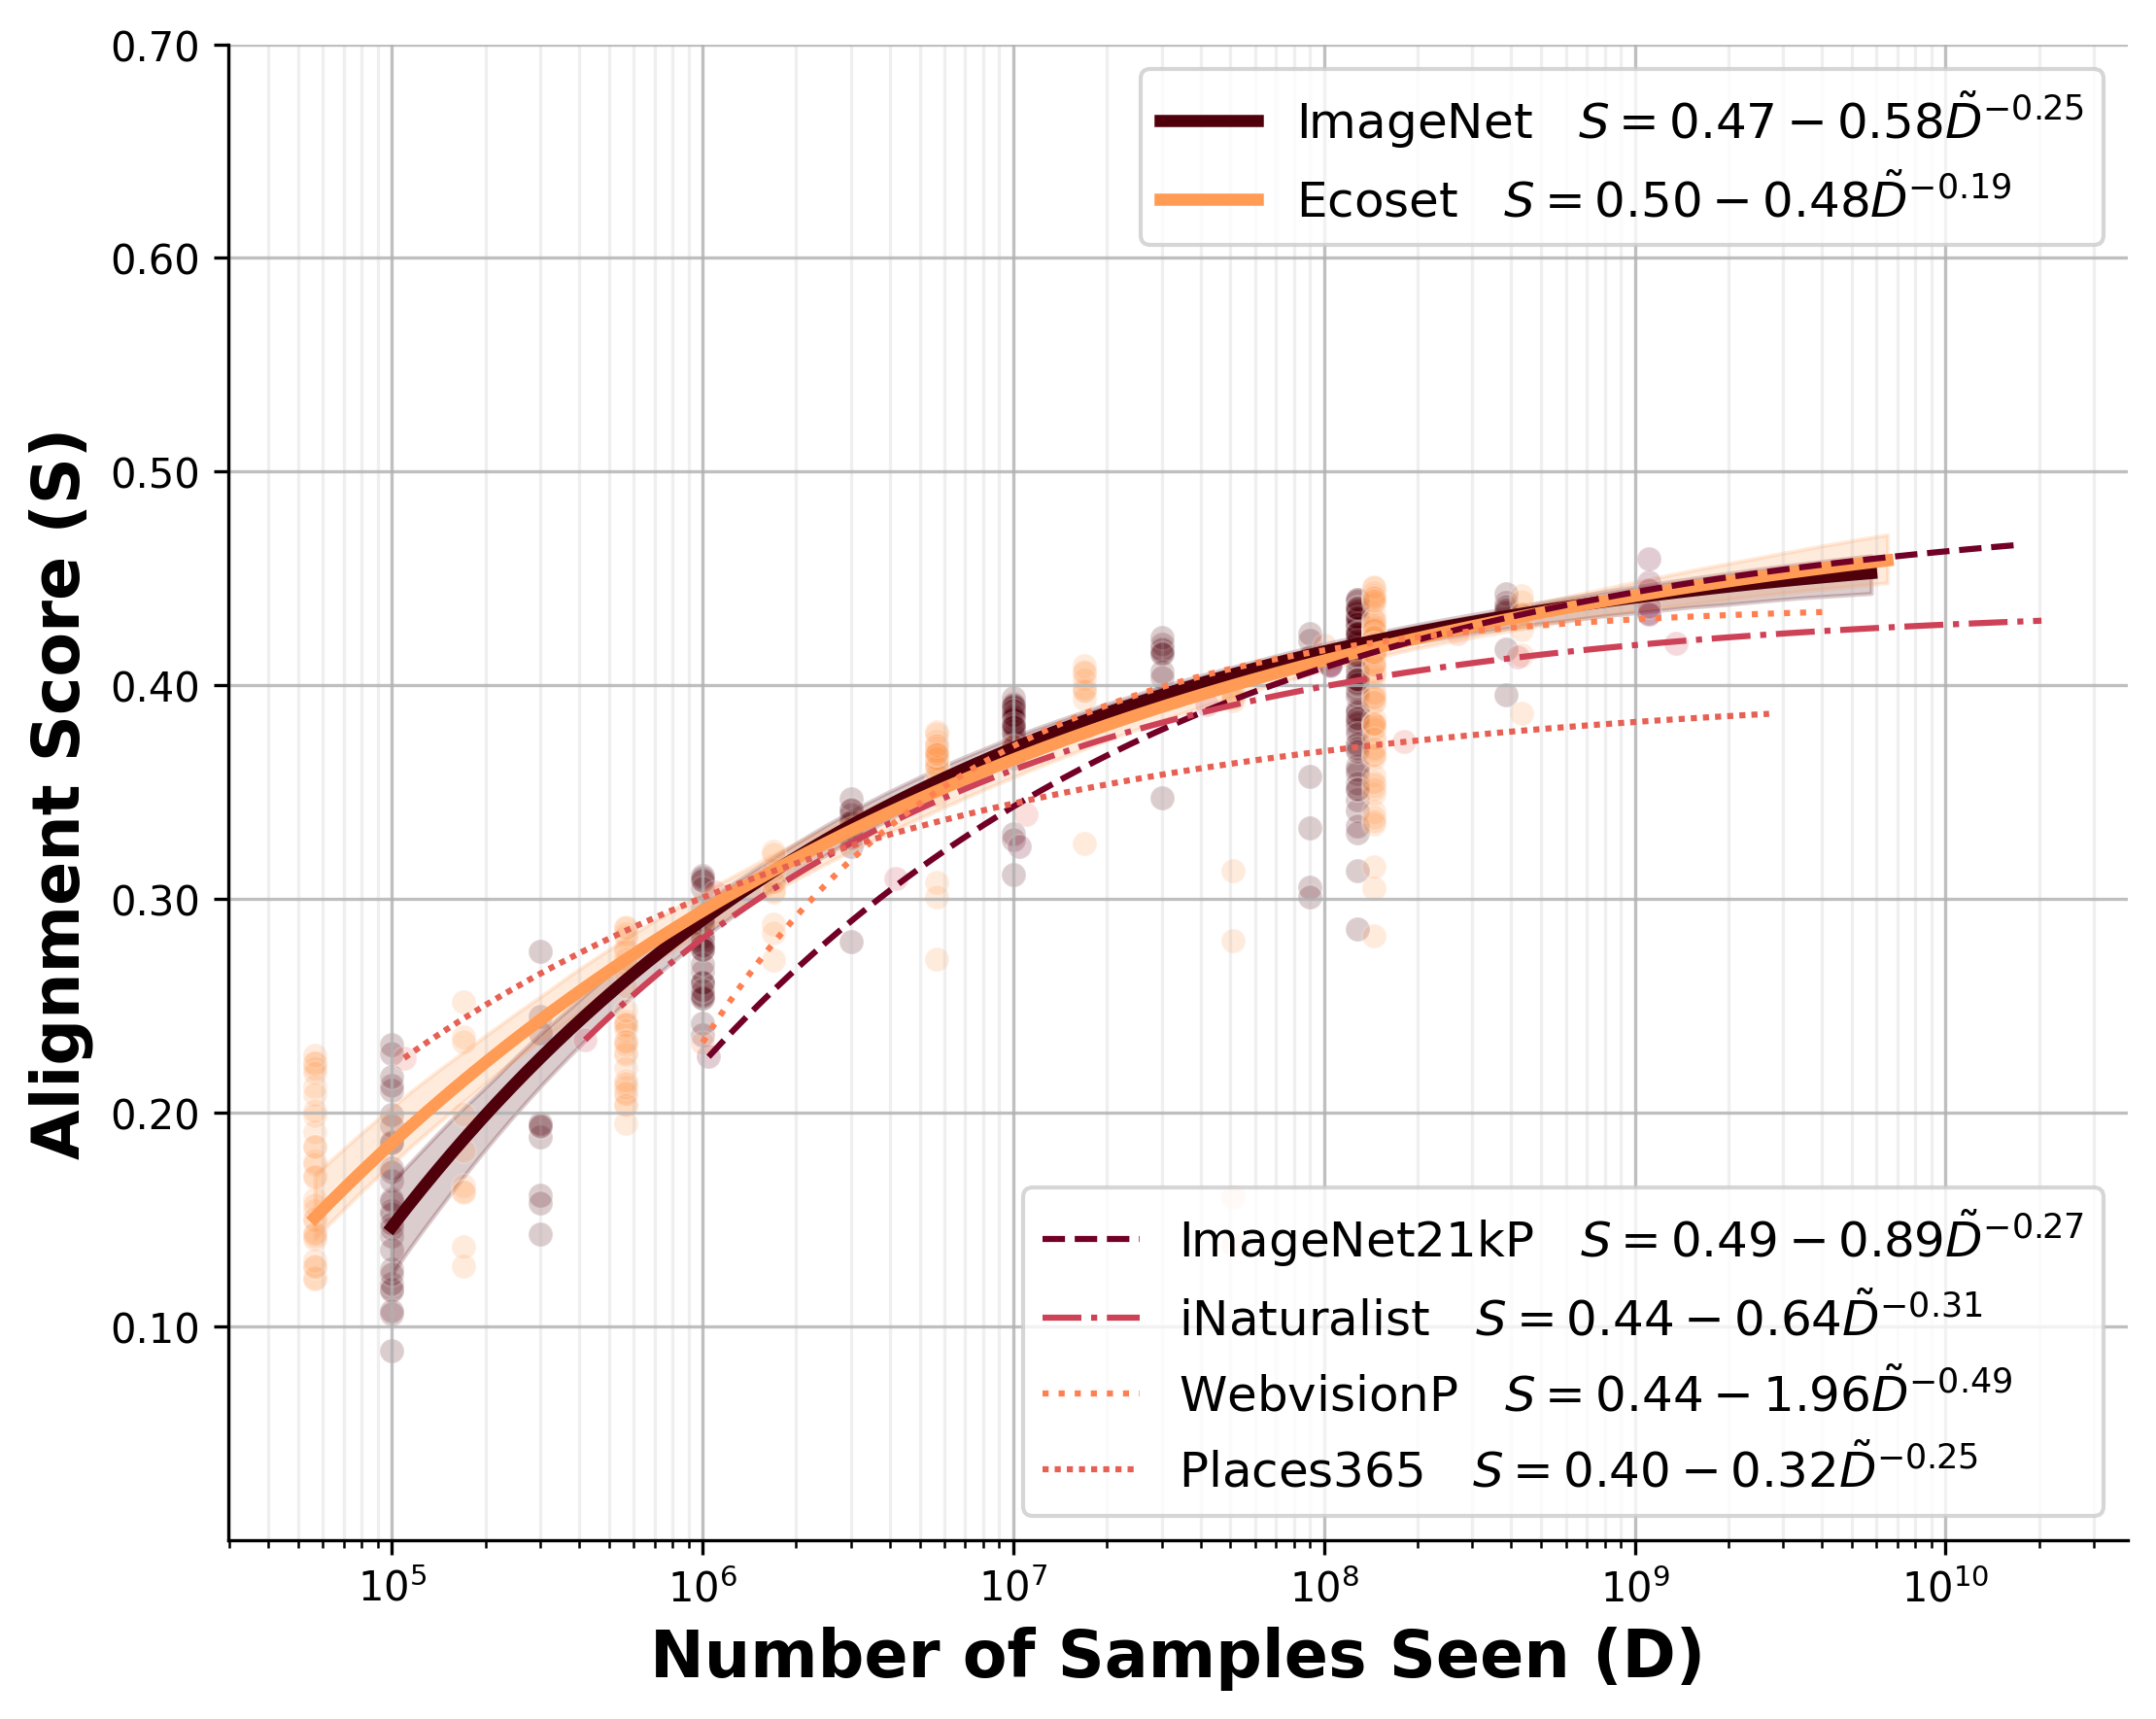

In [17]:
# sns.set_theme(style='whitegrid')
# sns.set_theme(style='ticks')


fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes
style_id = 0
for idx, ds in enumerate(dataset):

    df_plot = all_df[ds]
    optimized_params = optimized_params_dict[ds]
    opt_params_boot = opt_params_boot_dict[ds]
    L = LOSS_FUNCTIONS[L_viz_dict[ds]]
    x_scaler = x_scale_dict[ds]
    X = df_plot.n_samples_seen.values / x_scaler
    
    color = color_palette[dataset2colorid[ds]]
    sns.scatterplot(data=df_plot, x='n_samples_seen', y='score', ax=ax, color=color, alpha=alpha_scatter)
    if ds in ['imagenet', 'ecoset']:
        plot_reg(X, optimized_params, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=True, alpha=alpha_fit)
        plot_confidence_intervals(X, opt_params_boot, L, ax, color=color, x_extend=x_extend, x_scaler=x_scaler, alpha=alpha_ci, percentile=95.0, invert_y=True)
    else:
        linestyle = '-.'
        linestyle = linestyles[style_id]
        style_id += 1
        linewidth_ = linewidth / 2
        
        plot_reg(X, optimized_params, L, ax, color=color, x_extend=x_extend, linestyle=linestyle, X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth_, legend=True, alpha=alpha_fit)




ax.set_xscale('log')
ax.set_ylim(0, 0.5)
ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Number of Samples Seen (D)', fontsize=16, fontweight='bold')
ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
# ax.set_title(arch_family, fontsize=20, fontweight='bold')
ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

handles, labels = ax.get_legend_handles_labels()
labels_curves = [
    'ImageNet   ' + labels[0],
    'Ecoset   '  + labels[1],
]
handles_curves = handles[:len(labels_curves)]
legent_curves = ax.legend(handles_curves, labels_curves, fontsize=12)


labels_curves2 = [
    'ImageNet21kP   ' + labels[2],
    'iNaturalist   ' + labels[3],
    'WebvisionP   ' + labels[4],
    'Places365   ' + labels[5],
]
handles_curves2 = handles[len(labels_curves):]
legent_curves2 = ax.legend(handles_curves2, labels_curves2, fontsize=12, loc='lower right')

ax.add_artist(legent_curves)



ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()




figures_dir = '../figures'
fig_name = 'fig3_sample_scaling'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)

In [18]:
handles